This notebook contains a bunch of experiments to determine the optimal learning rate value for different optimizers. The reference model is a CNN with 3 convolutional blocks; the dataset is an augmented version of the CBIS dataset.

# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


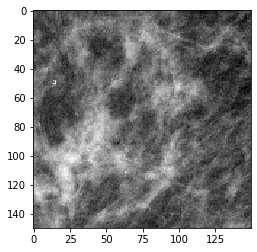

Label: 1


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [0]:
def create_cnn():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Learning rate estimation

The following experiment involves four of the most popular optimizers for NNs: SGD, RMSprop, Adam and Nadam.
In order to roughly approximate the range of reasonable values of learning rate for each optimizer, a simple strategy is adopted. Starting with a very low LR, its value is slightly increased at the end of each epoch. Initially, the network will learn slowly, because a small LR does now allow large weight updates, hence the loss will remain more or less constant. 
Then, the LR increases and the loss starts decreasing. At some point, however, the learning rate becomes so big that updates cause large and unpredictable fluctuations of the loss, and the network basically starts diverging.

In practice, the loss will start from a value around 0.69, corresponding to random prediction. After it gets lower a certain threshold, let's say 0.6, one can safely assume that the network started learning, and will eventually reach a loss minimum. Later, as soon as the weights diverge and the network goes back to random prediction, the training is stopped.


In [0]:
loss_lower_threshold = 0.60
loss_upper_threshold = 0.69

class StopOnDivergingLoss(Callback): 
    def on_epoch_end(self, epoch, logs={}):
        global low_reached
        if logs.get('loss') < loss_lower_threshold:
            low_reached = True
        if logs.get('loss') > loss_upper_threshold and low_reached:   
            print("\nStopping training!")   
            self.model.stop_training = True

# Callback for monitoring the loss at each learning rate
class LossLRCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr2loss[opt][0].append(keras.backend.eval(self.model.optimizer.lr))
        lr2loss[opt][1].append(logs['loss'])

# Callback to update the learning rate
lr_inc_rate = 1.1
def lr_scheduler(epoch):
    new_lr = lr_begin*(lr_inc_rate**epoch)
    print("Learning rate: %.7f" % new_lr)
    return new_lr

In [0]:
opts = [SGD, RMSprop, Adam, Nadam]

initial_lr = {
    SGD: 1e-3,
    RMSprop: 1e-5,
    Adam: 1e-6,
    Nadam: 1e-6
}

lr2loss = {
    SGD: [[], []],
    RMSprop: [[], []],
    Adam: [[], []],
    Nadam: [[], []]
}

# For each optimizer, perform a run incrementing the learning rate after every
# epoch, and keep track of the results
for opt in opts:
    print("Optimizer: " + opt.__name__)
    cnn = create_cnn()

    lr_begin = initial_lr[opt]
    low_reached = False
    stop_on_diverging_loss = StopOnDivergingLoss()
    losslrcb = LossLRCallback()
    lrschedulecb = keras.callbacks.LearningRateScheduler(lr_scheduler)

    cnn.compile(
                optimizer=opt(learning_rate=lr_begin),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    history = cnn.fit_generator(
                train_generator,
                steps_per_epoch=n_train_img // 128,
                epochs=300,
                validation_data=validation_generator,
                callbacks=[stop_on_diverging_loss, losslrcb, lrschedulecb],
                shuffle=True,
                verbose=1,
                initial_epoch=0)

Optimizer: SGD
Learning rate: 0.0010000
Epoch 1/300
20/20 [==============================] - 7s 366ms/step - loss: 0.6914 - acc: 0.5541 - val_loss: 0.6925 - val_acc: 0.5290
Learning rate: 0.0011000
Epoch 2/300
20/20 [==============================] - 6s 311ms/step - loss: 0.6919 - acc: 0.5378 - val_loss: 0.6925 - val_acc: 0.5308
Learning rate: 0.0012100
Epoch 3/300
20/20 [==============================] - 6s 312ms/step - loss: 0.6905 - acc: 0.5517 - val_loss: 0.6923 - val_acc: 0.5308
Learning rate: 0.0013310
Epoch 4/300
20/20 [==============================] - 6s 310ms/step - loss: 0.6908 - acc: 0.5434 - val_loss: 0.6922 - val_acc: 0.5308
Learning rate: 0.0014641
Epoch 5/300
20/20 [==============================] - 6s 311ms/step - loss: 0.6902 - acc: 0.5489 - val_loss: 0.6923 - val_acc: 0.5308
Learning rate: 0.0016105
Epoch 6/300
20/20 [==============================] - 7s 355ms/step - loss: 0.6899 - acc: 0.5497 - val_loss: 0.6921 - val_acc: 0.5308
Learning rate: 0.0017716
Epoch 7/300


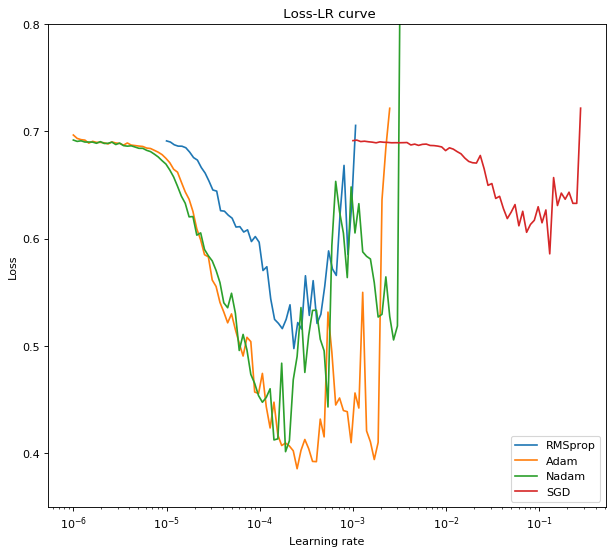

In [0]:
# Plot the loss obtained at different learning rates

plt.figure(figsize=(9, 8), dpi=80, facecolor='w', edgecolor='k')
for opt in opts:
    plt.xscale('log')
    plt.ylim(0.35, 0.8)
    plt.plot(lr2loss[opt][0], lr2loss[opt][1], label=opt.__name__)
    plt.title(' Loss-LR curve')
plt.ylabel('Loss')
plt.xlabel('Learning rate')
plt.legend(loc='lower right')
plt.show()

The graph above clearly shows that learning rate plays a decisive role during the training. When it is too high, weight updates become too large and the network becomes unstable, failing to converge towards the loss minimum. On the other hand, if it set too low, the network learns slowly and we observe modest improvements between two consecutive epochs.
The global minimum of the Loss-LR curve indicates the point where the learning rate starts causing instabilities, hence choosing a greater value is discouraged.
Ideally, the best one is in the region with the fastest descent of loss function, that is where the plotted curve is steepest (negatively). It should be also noted that, in a stable network, loss variations naturally decrease over time, even if the LR remains constant, as a consequence of the gradual convergence of the weights towards the optimum. Thus, the steepest point represents may not directly represent the optimal LR, but a lower bound for it.
That said, a practical way to choose an adequate LR for an optimizer is to pick a value between the steepest point and the minimum, e.g. in the middle of this region.

In this case, reasonable choices are:

*   **SGD**     : 3e-2
*   **RMSProp** : 1e-4
*   **Adam**    : 1e-4
*   **Nadam**   : 1e-4

Note how these values slightly differ from the Keras default ones.

# Optimizers comparison

In the following experiment each optimizer runs once for 100 epochs, with the previously determined learning rate.

In [0]:
# For each optimizer, execute a training run with the previously determined best learning rate

optimal_lr = {
    SGD: 3e-2,
    RMSprop: 1e-4,
    Adam: 1e-4,
    Nadam: 1e-4
}

histories = {}

for opt in opts:
    print("Optimizer: " + opt.__name__)
    cnn = create_cnn()

    cnn.compile(
                optimizer=opt(learning_rate=optimal_lr[opt]),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    histories[opt] = cnn.fit_generator(
                train_generator,
                steps_per_epoch=n_train_img // 128,
                epochs=100,
                validation_data=validation_generator,
                shuffle=True,
                verbose=1,
                initial_epoch=0)

Optimizer: SGD
Epoch 1/100
20/20 [==============================] - 6s 277ms/step - loss: 0.6923 - acc: 0.5259 - val_loss: 0.6889 - val_acc: 0.5645
Epoch 2/100
20/20 [==============================] - 5s 246ms/step - loss: 0.6908 - acc: 0.5434 - val_loss: 0.6864 - val_acc: 0.5645
Epoch 3/100
20/20 [==============================] - 5s 233ms/step - loss: 0.6894 - acc: 0.5498 - val_loss: 0.6855 - val_acc: 0.5645
Epoch 4/100
20/20 [==============================] - 5s 235ms/step - loss: 0.6897 - acc: 0.5319 - val_loss: 0.6869 - val_acc: 0.5645
Epoch 5/100
20/20 [==============================] - 4s 224ms/step - loss: 0.6880 - acc: 0.5469 - val_loss: 0.6866 - val_acc: 0.5607
Epoch 6/100
20/20 [==============================] - 5s 264ms/step - loss: 0.6863 - acc: 0.5707 - val_loss: 0.6899 - val_acc: 0.5290
Epoch 7/100
20/20 [==============================] - 5s 236ms/step - loss: 0.6846 - acc: 0.5584 - val_loss: 0.6834 - val_acc: 0.5645
Epoch 8/100
20/20 [==============================] - 5

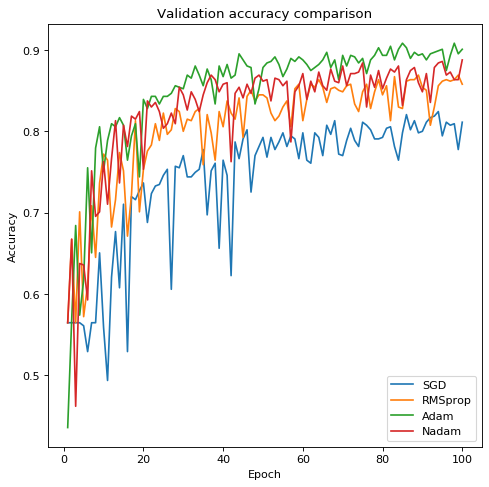

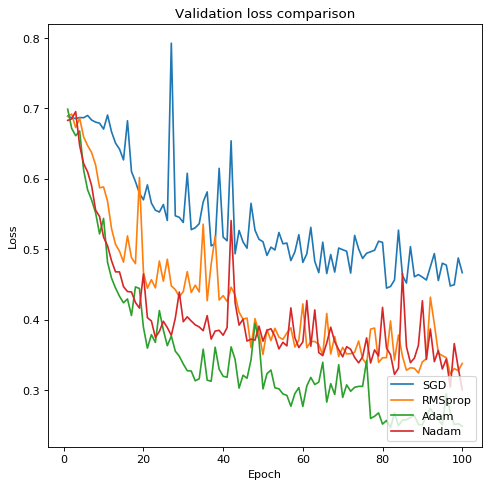

In [0]:
# Validation accuracy

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
for opt in opts:
    val_acc = histories[opt].history['val_acc']
    epochs = range(1, len(val_acc)+1)
    plt.plot(epochs, val_acc, label=opt.__name__)
plt.legend(loc='lower right')

# Validation loss

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for opt in opts:
    val_loss = histories[opt].history['val_loss']
    epochs = range(1, len(val_loss)+1)
    plt.plot(epochs, val_loss, label=opt.__name__)
plt.legend(loc='lower right')

The graphs shows that SGD is relatively weak with respect to the other optimizers. Adam converges faster than RMSprop and Nadam, whose curves are quite similar.

# Learning rate verification

Now that approximate values for the learning rate have been discovered, one may try to directly experiment with different nearby values and find which one works best.

## RMSprop

In [0]:
# Try RMSprop with different learning rates

lr_to_test = (1e-5, 1e-4, 1e-3)
opt = RMSprop

histories = {}

for lr in lr_to_test:
    print("RMS [lr = %.5f]: " % lr)
    cnn = create_cnn()
    cnn.compile(
                optimizer=opt(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    histories[lr] = cnn.fit_generator(
                train_generator,
                steps_per_epoch=n_train_img // 128,
                epochs=100,
                validation_data=validation_generator,
                shuffle=True,
                verbose=1,
                initial_epoch=0)

RMS [lr = 0.00001]: 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
20/20 [==============================] - 11s 528ms/step - loss: 0.6913 - acc: 0.5277 - val_loss: 0.6843 - val_acc: 0.5701
Epoch 2/100
20/20 [==============================] - 5s 238ms/step - loss: 0.6915 - acc: 0.5386 - val_loss: 0.6859 - val_acc: 0.5701
Epoch 3/100
20/20 [==============================] - 5s 244ms/step - loss: 0.6910 - acc: 0.5332 - val_loss: 0.6886 - val_acc: 0.5589
Epoch 4/100
20/20 [==============================] - 5s 235ms/step - loss: 0.6892 - acc: 0.5434 - val_loss: 0.6833 - val_acc: 0.5701
Epoch 5/100
20/20 [==============================] - 4s 221ms/step - loss: 0.6887 - acc: 0.5379 - val_loss: 0.6832 - val_acc: 0.5701
Epoch 6/100
20/20 [==============================] - 5s 268ms/step - loss: 0.6878 - acc: 0.5394 - val_loss: 0.6863 - val_acc: 0.7215
Epoch

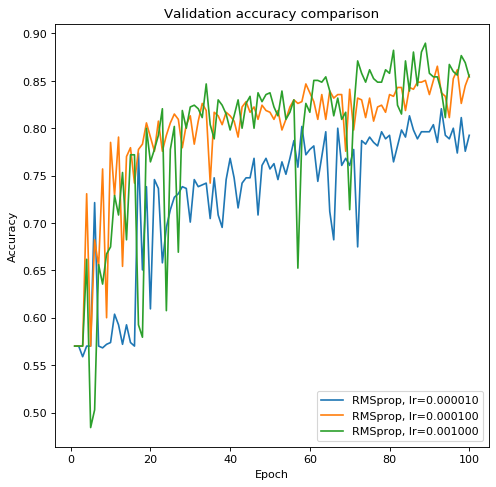

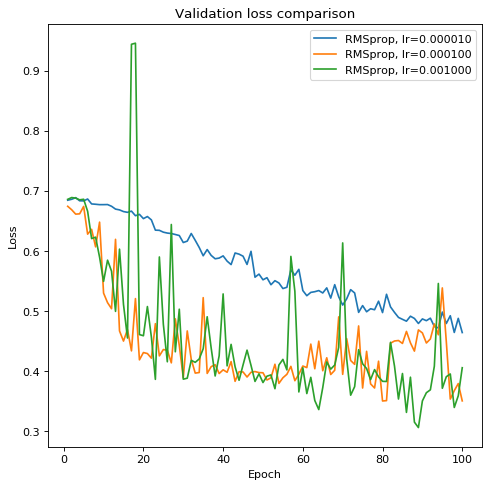

In [0]:
# Validation accuracy

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
for lr in lr_to_test:
    val_acc = histories[lr].history['val_acc']
    epochs = range(1, len(val_acc)+1)
    plt.plot(epochs, val_acc, label=("%s, lr=%f" % (opt.__name__, lr)))
plt.legend(loc='lower right')

# Validation loss

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for lr in lr_to_test:
    val_loss = histories[lr].history['val_loss']
    epochs = range(1, len(val_loss)+1)
    plt.plot(epochs, val_loss, label=("%s, lr=%f" % (opt.__name__, lr)))
plt.legend(loc='upper right');

**Result**: Values between 1e-4 and 1e-3 produce similar results. 1e-3 is more noisy, but converges a bit faster. On the other hand, 1e-5 represents an excessively low value.

## Adam

In [0]:
# Try Adam with different learning rates

lr_to_test = (1e-5, 1e-4, 1e-3)
opt = Adam

histories = {}

for lr in lr_to_test:
    print("Adam [lr = %.5f]: " % lr)
    cnn = create_cnn()
    cnn.compile(
                optimizer=opt(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    histories[lr] = cnn.fit_generator(
                train_generator,
                steps_per_epoch=n_train_img // 128,
                epochs=100,
                validation_data=validation_generator,
                shuffle=True,
                verbose=1,
                initial_epoch=0)

Adam [lr = 0.00001]: 
Epoch 1/100
20/20 [==============================] - 6s 297ms/step - loss: 0.6918 - acc: 0.5386 - val_loss: 0.6858 - val_acc: 0.5701
Epoch 2/100
20/20 [==============================] - 5s 252ms/step - loss: 0.6907 - acc: 0.5387 - val_loss: 0.6856 - val_acc: 0.5701
Epoch 3/100
20/20 [==============================] - 5s 236ms/step - loss: 0.6897 - acc: 0.5361 - val_loss: 0.6852 - val_acc: 0.5701
Epoch 4/100
20/20 [==============================] - 5s 240ms/step - loss: 0.6893 - acc: 0.5410 - val_loss: 0.6839 - val_acc: 0.5701
Epoch 5/100
20/20 [==============================] - 4s 223ms/step - loss: 0.6876 - acc: 0.5394 - val_loss: 0.6817 - val_acc: 0.5701
Epoch 6/100
20/20 [==============================] - 5s 271ms/step - loss: 0.6871 - acc: 0.5386 - val_loss: 0.6809 - val_acc: 0.5682
Epoch 7/100
20/20 [==============================] - 5s 239ms/step - loss: 0.6858 - acc: 0.5378 - val_loss: 0.6802 - val_acc: 0.5701
Epoch 8/100
20/20 [============================

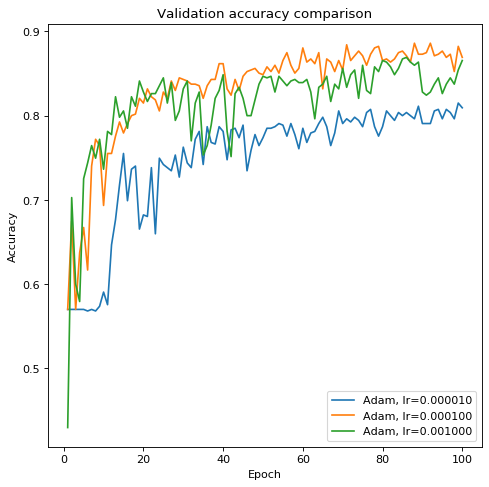

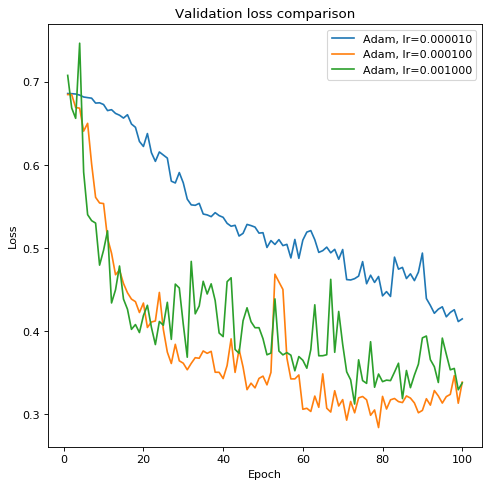

In [0]:
# Validation accuracy

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
for lr in lr_to_test:
    val_acc = histories[lr].history['val_acc']
    epochs = range(1, len(val_acc)+1)
    plt.plot(epochs, val_acc, label=("%s, lr=%f" % (opt.__name__, lr)))
plt.legend(loc='lower right')

# Validation loss

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for lr in lr_to_test:
    val_loss = histories[lr].history['val_loss']
    epochs = range(1, len(val_loss)+1)
    plt.plot(epochs, val_loss, label=("%s, lr=%f" % (opt.__name__, lr)))
plt.legend(loc='upper right');

**Result**: 1e-5 is definitely a bad choice, as the network converges very slowly. Interestingly, 1e-4 produces better results than 1e-3.